# Load documents with IDs


In [2]:
import requests

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'

docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()



In [3]:
documents[1]


{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp',
 'id': '1f6520ca'}

# Load ground truth

In [4]:
import pandas as pd

In [5]:
base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

In [6]:
df_ground_truth = pd.read_csv(ground_truth_url)


In [7]:
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [8]:
ground_truth[1]


{'question': 'Can you provide a link to sign up?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [9]:
doc_idx = {d['id']: d for d in documents}

# Index data

In [10]:
from sentence_transformers import SentenceTransformer

/home/mahtab/.local/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer, models

# Create a SentenceTransformer model with mean pooling
word_embedding_model = models.Transformer(model_name_or_path="/home/mahtab/transformers/all-MiniLM-L6-v2")
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
sentence_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [13]:
from elasticsearch import Elasticsearch
import urllib3

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

es_client = Elasticsearch('https://localhost:9200',
                           http_auth=('elastic', 'xMR77YWEPbFGsMJvin_7'),
                           verify_certs=False) 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

/home/mahtab/.local/lib/python3.10/site-packages/elasticsearch/_sync/client/__init__.py:399: SecurityWarning: Connecting to 'https://localhost:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(
/tmp/ipykernel_11717/2431856763.py:6: DeprecationWarning: The 'http_auth' parameter is deprecated. Use 'basic_auth' or 'bearer_auth' parameters instead
  es_client = Elasticsearch('https://localhost:9200',


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [14]:
for doc in documents:
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = sentence_model.encode(question + ' ' + text)
    es_client.index(index=index_name, document=doc)

# Retrieval

In [15]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

In [16]:
def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = sentence_model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [17]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'section': 'General course-related questions',
  'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'id': '5170565b'},
 {'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'section': 'General course-related questions',
  'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'id': '39fda9f0'},
 {'text': 'We won’t re-record the course videos. The focus of the course and the skills we want to teach remained the sam

# The RAG flow

In [18]:
def build_prompt(query, search_results):
    prompt_template = """
    You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
    Use only the facts from the CONTEXT when answering the QUESTION.

    QUESTION: {question}

    CONTEXT: 
    {context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt 

In [19]:
from openai import OpenAI
client = OpenAI(
    base_url='http://localhost:11434/v1/',
    api_key='ollama'
)

In [20]:
def llm(prompt):
    response = client.chat.completions.create(
        model='phi3',
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [21]:
def rag(query: dict) -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt)
    return answer

In [37]:
rag(ground_truth[10])


'According to the FAQ database, if you miss a session of "BuildYourOwnNeuralNetworkeconomist.in," all sessions are recorded which means everything is on tape so that no crucial information will be missed by learners like yourself who might not attend every live stream for various reasons such as schedule conflicts or simply forgetting to log in at the right time.\n\nThis ensures inclusivity and allows students unfettered accessibility, hence providing equal learning opportunities regardless of scheduling issues or other impromptu unavailabilities on part of this course\'s instructors which includes offering recordings for office hour sessions as well as inviting learners to pose their queries ahead in Slack. Remember the recorded lectures and pre-recorded live session, you can check them both easily available under YouTube Playlist. \n\nAlthough previous iterations videos are used but no longer needed due to lack of essential updates in course content overtime which keeps our syllabus 

# Cosine similarity metric


In [22]:
answer_orig = 'Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = sentence_model.encode(answer_llm)
v_orig = sentence_model.encode(answer_orig)

v_llm.dot(v_orig)

8.669298

In [23]:
answers = {}
smaller_ground_truth = ground_truth[:5]

In [24]:
for i, rec in enumerate(smaller_ground_truth):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [ ]:
answers


In [27]:
results_phi3 = [None]*len(smaller_ground_truth)

for i, val in answers.items():
    results_phi3[i]=val.copy()
    results_phi3[i].update(smaller_ground_truth[i])

In [28]:
import pandas as pd

In [29]:
df_phi3 = pd.DataFrame(results_phi3)

In [31]:
df_phi3.to_csv('results-phi3.csv', index=False)


In [32]:
df_phi3

,answer_llm,answer_orig,document,question,course
0,"To sign up for the course, visit the provided ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,"I'm sorry, but it seems there is no specific i...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,As a course teaching assistant for the Machine...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"Based on the provided context, yes, students n...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [33]:
results_phi3 = df_phi3.to_dict(orient='records')


In [35]:
results_phi3


[{'answer_llm': "To sign up for the course, visit the provided link http://mlzoomcamp.com/#syllabus and there you can see all necessary options to enroll or join if you've already joined! Please note that even if past iterations have started, future cohort courses with a live component will kick off in September 2023. Feel free to reach out via the course page for help regarding accessibility of previous materials and projects from former learners starting as early as October (and they might be helpful).",
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Where can I sign up for

In [39]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = sentence_model.encode(answer_llm)
    v_orig = sentence_model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [40]:
similarity = []

for record in results_phi3:
    sim = compute_similarity(record)
    similarity.append(sim)

In [41]:
similarity

[1.8950089, 0.63075495, 2.7477698, 1.1537964, 1.4594065]

In [42]:
df_phi3['cosine'] = similarity
df_phi3['cosine'].describe()

count    5.000000
mean     1.577347
std      0.800022
min      0.630755
25%      1.153796
50%      1.459406
75%      1.895009
max      2.747770
Name: cosine, dtype: float64

In [50]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [57]:
import seaborn as sns
import matplotlib.pyplot as plt



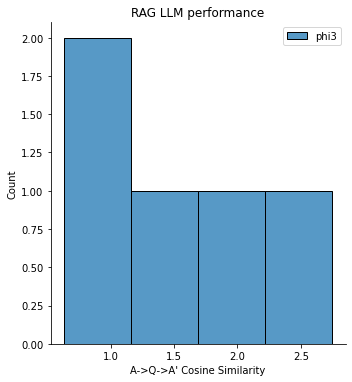

In [60]:
sns.displot(df_phi3['cosine'].values, label='phi3')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

# LLM-as-a-Judge


In [92]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT","Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT","Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [93]:
df_sample = df_phi3.sample(n=5, random_state=1)
samples = df_sample.to_dict(orient='records')



In [94]:
record = samples[0]


In [95]:
record

{'answer_llm': "As a course teaching assistant for the Machine Learning course, I'm happy to inform you that yes, there is an FAQ section available to address frequently asked technical questions regarding our course! Please refer to Airtable base URL where all these resources are listed: https://airtable.com/shryxwLd0COOEaqXo?p=4DZc7sIdHJ&i=3\nAlso, for general advice on how to get started and access course materials after joining the Zoomcamp Machine Learning Course 2023: Go directly to our official ML Camp website (http://mlzoomcamp.com/) or you can use this link http://airtable.com/shryxwLd0COOEaqXo?p=4DZc7sIdHJ&i=17 which will direct right into the course materials and furthermore to our comprehensive GitHub repo (https://github.com/DataTalksClub/machine-learning-zoomcamp/) that holds all resources from theory, assignments and projects related to this Machine Learning Zoomcamp! ",
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently

In [96]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work
Generated Question: Is there an FAQ for this Machine Learning course?
Generated Answer: As a course teaching assistant for the Machine Learning course, I'm happy to inform you that yes, there is an FAQ sect

In [97]:
answer = llm(prompt)


In [108]:
answer

'```json\n\n{\n\n  "Relevance": "PARTLY_RELEVANT",\n\n  "Explanation": "The generated answer partially meets the original question by acknowledging an FAQ section and providing its source. However, it deviates from directly answering \'Is there an FAQ for this Machine Learning course?\' instead of referencing to a general advice on getting started with accessing resources as done in the provided URL."\n\n}\n\n```'

In [107]:
cleaned_string = answer.strip('```json').strip().replace('\\n', '')
cleaned_string = cleaned_string.replace('\n', '')
cleaned_string

'{  "Relevance": "PARTLY_RELEVANT",  "Explanation": "The generated answer partially meets the original question by acknowledging an FAQ section and providing its source. However, it deviates from directly answering \'Is there an FAQ for this Machine Learning course?\' instead of referencing to a general advice on getting started with accessing resources as done in the provided URL."}'

In [109]:
json.loads(cleaned_string)

{'Relevance': 'PARTLY_RELEVANT',
 'Explanation': "The generated answer partially meets the original question by acknowledging an FAQ section and providing its source. However, it deviates from directly answering 'Is there an FAQ for this Machine Learning course?' instead of referencing to a general advice on getting started with accessing resources as done in the provided URL."}

In [72]:
import json

In [74]:
evaluations = []

for record in samples:
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt)
    evaluations.append(evaluation)

In [86]:
evaluations[0]


'```json\n\n{\n\n  "Relevance": "NON_RELEVANT",\n\n  "Explanation": "The generated answer is non-relevant because it provides several pieces of unnecessary and unrelated information. It mentions being a course teaching assistant, discusses general advice on accessing the Zoomcamp ML Course materials, directs to an external link that doesn\'t specifically address FAQ questions about data engineering within the course context."\n\n}\n\n```'

In [111]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    cleaned_string = str_eval.strip('```json').strip().replace('\\n', '')
    cleaned_string = cleaned_string.replace('\n', '')
    json_eval = json.loads(cleaned_string)
    json_evaluations.append(json_eval)

In [112]:
json_evaluations

[{'Relevance': 'NON_RELEVANT',
  'Explanation': "The generated answer is non-relevant because it provides several pieces of unnecessary and unrelated information. It mentions being a course teaching assistant, discusses general advice on accessing the Zoomcamp ML Course materials, directs to an external link that doesn't specifically address FAQ questions about data engineering within the course context."},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': "The generated answer does not directly follow the intent and content of the RAG system's expected action, which is to provide a straightforward link or process for signing up. Instead, it veers off-topic by discussing general practices unrelated points without addressing any signup method within the context provided."},
 {'Relevance': 'SUBSTANTIALLY DIFFERENT FROM NORMALSPIRIT OF THE ORIGINAL ANSWER',
  'Explanation': "The generated answer fails to directly address the purpose of creating and referencing a FAQ document for guidance. I

In [113]:
df_evaluations = pd.DataFrame(json_evaluations)


In [115]:
df_evaluations.Relevance.value_counts()

Relevance
NON_RELEVANT                                                        3
SUBSTANTIALLY DIFFERENT FROM NORMALSPIRIT OF THE ORIGINAL ANSWER    1
Name: count, dtype: int64

In [116]:
df_phi3.to_csv('results-phi3-cosine.csv', index=False)


In [117]:
df_evaluations.to_csv('results-eavaluation.csv', index=False)